## Validation of data

You sohuld have, valid and train output from this cell. They are the folders of our training and validation datasets.

In [33]:
import os
# List all items in the extracted folder
items = os.listdir("Hot Dog Detection COCO")
print("Contents of the extracted folder:")
for item in items:
    print(item)

## COCO dataset location
COCO_BASE = "Hot Dog Detection COCO"

COCO_TRAIN = os.path.join(COCO_BASE, "train")
COCO_VALID = os.path.join(COCO_BASE, "valid")


Contents of the extracted folder:
valid
train


### Set the device we will use for the rest of the training

In [34]:
import torch
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Data Ingestion

We use our custom Dataset class to load the COCO data. Then use a DataLoader.

In [45]:
## Create the dataset and dataloader objects for our dataset
# ! pip install pycocotools ### Needed this is Google Colab
import os
import torch
from torchvision import transforms
from torch.utils.data import DataLoader
from hot_dog_dataset import HotDogDataset
import torch

BATCH_SIZE = 6

# Data transformations with resizing
transform = transforms.Compose([
    transforms.Resize((256, 256)),  # Resize images to 256x256
    transforms.ToTensor(),          # Convert images to tensor format, normalizes image pixel values
])

# Custom collate function to handle variable-length targets (some images may have 0-N bounding boxes)
def custom_collate_fn(batch):
    images, targets = zip(*batch)

    # Stack images to form a batch
    images = torch.stack(images, dim=0)

    # Since targets are already in torch, just return
    return images, list(targets)

# Create instances of the dataset
train_data = HotDogDataset(root=COCO_TRAIN,
                              annFile=os.path.join(COCO_TRAIN, "_annotations.coco.json"),
                              transform=transform)

val_data = HotDogDataset(root=COCO_VALID,
                              annFile=os.path.join(COCO_VALID, "_annotations.coco.json"),
                              transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_data,
                          batch_size=BATCH_SIZE,
                          shuffle=True,
                        #   num_workers=2,
                          collate_fn=custom_collate_fn)

val_loader = DataLoader(val_data,
                        batch_size=BATCH_SIZE,
                        shuffle=False,
                        # num_workers=2,
                        collate_fn=custom_collate_fn)


loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.01s)
creating index...
index created!


Visualizing some of our training data using our DataLoader. We draw the truth bounding boxes around the hot dogs.

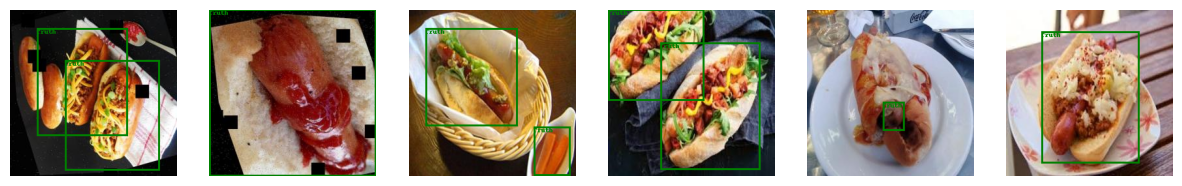

In [36]:
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
from PIL import ImageDraw

# Robust util function for drawing images
# Will draw the dataset images as well as inferred models if GlizzyNet is given
def visualize_images(images, targets, model=None, device='cpu', iou_threshold=0.5):
    """
    Visualize images with ground truth and optional predicted bounding boxes.

    Parameters:
    - images: list of tensors, the images to visualize.
    - targets: list of dicts, each containing 'boxes' (ground truth bounding boxes).
    - model: optional, a model to make predictions. If provided, predictions will be drawn in red.
    - device: str, device on which the model operates ('cpu' or 'cuda').
    - iou_threshold: float, IoU threshold for filtering predicted boxes.

    The function will visualize:
    - Ground truth boxes in green.
    - Predicted boxes (if model is provided) in red with confidence scores.
    """
    images = [image.to(device) for image in images]

    # If model is give, perform inference
    if model:
        outputs = model(images)

    fig, axs = plt.subplots(1, len(images), figsize=(15, 5))
    
    if len(images) == 1:
        axs = [axs]  # Ensure axs is iterable

    # Draw every image
    for img_idx, (image, target) in enumerate(zip(images, targets)):
        img = F.to_pil_image(image)
        draw = ImageDraw.Draw(img)

        # Draw ground truth boxes (green)
        for box in target['boxes']:
            draw.rectangle(list(box), outline="green", width=3)
            draw.text((box[0], box[1]), "Truth", fill="green")

        # If a model is provided, draw predicted boxes (red)
        if model:
            output = outputs[img_idx]
            for box, score in zip(output['boxes'], output['scores']):
                if score >= iou_threshold:  # Only draw boxes above the threshold
                    draw.rectangle(list(box), outline="red", width=3)
                    draw.text((box[0], box[1]), f" GlizzyNet: {score:.2f}", fill="red")

        axs[img_idx].imshow(img)
        axs[img_idx].axis('off')

    plt.show()

images, targets = next(iter(train_loader))
visualize_images(images, targets)

## Model Creation

We use our GlizzyNet class to create an instance for our model.

In [41]:
from glizzy_net import GlizzyNet

# # 2 classes (hot dog and background)
# # In Faster RCNN we want to freeze most of the already perfect layers, we only want to train the bounding box classifier
glizzy_net = GlizzyNet(num_classes=2, freeze_backbone=True, freeze_rpn=True, freeze_fpn=True)
glizzy_net = glizzy_net.get_model()

for name, param in glizzy_net.named_parameters():
    if param.requires_grad:
        print (name)

roi_heads.box_predictor.cls_score.weight
roi_heads.box_predictor.cls_score.bias
roi_heads.box_predictor.bbox_pred.weight
roi_heads.box_predictor.bbox_pred.bias


In [42]:
import os
import torch

# Constants for hyperparameters and training settings
LEARNING_RATE = 0.001
MOMENTUM = 0.95
WEIGHT_DECAY = 0.0005
NUM_EPOCHS = 15

# Checkpoint and log setting
CHECKPOINT_DIR = f"checkpoints_bs{BATCH_SIZE}" 
CHECKPOINT_INTERVAL = 1
LOG_INTERVAL = 10

# Initialize lists to store the average loss for each epoch
train_losses = []
val_losses = []

# Create the directory for saving checkpoints if it does not exist
os.makedirs(CHECKPOINT_DIR, exist_ok=True)

# Define optimizer using constants
optimizer = torch.optim.SGD(
    filter(lambda p: p.requires_grad, glizzy_net.parameters()),  # Filter parameters with requires_grad=True
    lr=LEARNING_RATE,
    momentum=MOMENTUM,
    weight_decay=WEIGHT_DECAY
)

# Training loop
for epoch in range(NUM_EPOCHS):
    glizzy_net.train()  # Set the model to training mode
    train_epoch_loss = 0
    num_train_batches = 0

    for batch_idx, (images, targets) in enumerate(train_loader):
        # Move images and targets to device, when I trained on google colab, this was cuda
        images = [image.to(device) for image in images]
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        # Check validity of targets (may be a redundant check), but here just in case
        for target in targets:
            if target['boxes'].size(0) == 0:
                continue

        # Forward pass
        loss_dict = glizzy_net(images, targets)
        losses = sum(loss for loss in loss_dict.values())

        # Backward pass and optimization
        optimizer.zero_grad()
        losses.backward()
        optimizer.step()

        train_epoch_loss += losses.item()
        num_train_batches += 1

        # Logging
        if (batch_idx + 1) % LOG_INTERVAL == 0:
            print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Batch [{batch_idx+1}/{len(train_loader)}], Loss: {losses.item():.4f}")

    # Calculate the average training loss for the epoch
    avg_train_loss = train_epoch_loss / num_train_batches
    train_losses.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed. Average Training Loss: {avg_train_loss:.4f}")

    # Validation loop
    val_epoch_loss = 0
    num_val_batches = 0

    with torch.no_grad():  # Disable gradient computation for validation
        for images, targets in val_loader:
            images = [image.to(device) for image in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            # Check validity of targets
            for target in targets:
                if target['boxes'].size(0) == 0:
                    continue

            # Forward pass
            loss_dict = glizzy_net(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            val_epoch_loss += losses.item()
            num_val_batches += 1

    # Calculate the average validation loss for the epoch
    avg_val_loss = val_epoch_loss / num_val_batches
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{NUM_EPOCHS}] completed. Average Validation Loss: {avg_val_loss:.4f}")


    # Save model checkpoint
    if (epoch + 1) % CHECKPOINT_INTERVAL == 0:
        checkpoint_path = os.path.join(CHECKPOINT_DIR, f"model_epoch_{epoch+1}.pth")
        torch.save(glizzy_net.state_dict(), checkpoint_path)
        print(f"Model checkpoint saved at {checkpoint_path}")

# Plotting the training loss
# print(train_losses, val_losses)

# Plotting the average training and validation loss per epoch
plt.figure(figsize=(10, 5))
plt.plot(range(1, NUM_EPOCHS + 1), train_losses, label='Training Loss', color='red', marker='o', linestyle='-')
plt.plot(range(1, NUM_EPOCHS + 1), val_losses, label='Validation Loss', color='blue', marker='o', linestyle='-')
plt.xlabel('Epoch')
plt.ylabel('Average Loss')
plt.title('Average Training and Validation Loss per Epoch')
plt.legend()
plt.grid(True)
plt.savefig('average_loss_per_epoch.png')
plt.show()

Epoch [1/15], Batch [10/415], Loss: 0.4709


KeyboardInterrupt: 

## Inference Testing

Using our saved "golden" model we perform inference testing. Some of the graphs in the report use the same code below, but in Google Colab on an A100 to accelerate the process.

Beginning warm-up
Beginning Test
[1.6936688423156738, 1.5833842754364014, 1.561453104019165, 1.5729682445526123, 1.5427563190460205, 1.5953469276428223, 1.6274962425231934, 1.61008882522583, 1.601963758468628, 1.6231729984283447]
Average latency over 10 iterations: 1601.23 ms
Beginning warm-up
Beginning Test
[3.8962597846984863, 3.833461046218872, 3.851746082305908, 3.9723777770996094, 4.069928884506226, 3.920332193374634, 3.8878252506256104, 3.8449082374572754, 3.8706510066986084, 3.877347946166992]
Average latency over 10 iterations: 3902.48 ms
Beginning warm-up
Beginning Test
[5.939982891082764, 5.365814924240112, 5.957865238189697, 6.0917627811431885, 5.9534690380096436, 5.389672040939331, 5.586895942687988, 5.367630958557129, 5.919246196746826, 5.312303066253662]
Average latency over 10 iterations: 5688.46 ms
Beginning warm-up
Beginning Test
[11.357056856155396, 11.047977924346924, 11.048439025878906, 11.136547803878784, 11.179564952850342, 11.120722770690918, 11.180729150772095, 

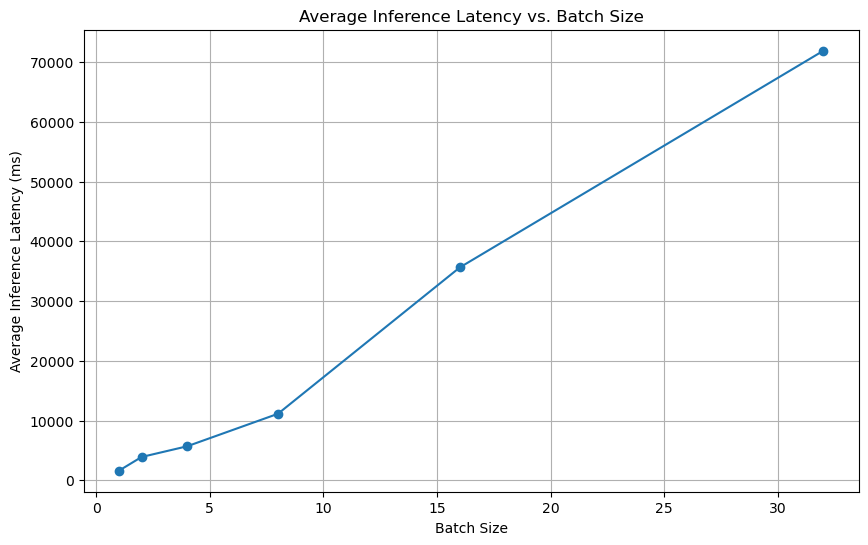

In [43]:
import torch
from torchvision.transforms import functional as F
from torch.utils.data import DataLoader
from PIL import Image
import time

TEST_ITERATIONS = 10

test_images = []

BATCH_SIZES = [1, 2, 4, 8, 16, 32]

# Instantiate GlizzyNet
hotdog_detector = GlizzyNet(num_classes=2, freeze_backbone=True, freeze_rpn=True, freeze_fpn=True)
glizzy_net = hotdog_detector.get_model()


# Load the saved, checkpointed model
checkpoint = os.path.join(f"checkpoints_bs64", "model_epoch_15.pth")
glizzy_net.load_state_dict(torch.load(checkpoint, map_location=torch.device(device)))

glizzy_net.eval()

# Our inference function
def inference_latency(model, val_loader):
    
    print(f"Beginning warm-up")
    # WArm up iterations, no gradient computations needed
    with torch.no_grad():
        for _ in range(TEST_ITERATIONS//2):
            for images, _ in val_loader:
           
                images = images.to(device)
                _ = model(images)
                break # run only one batch
    
    print(f"Beginning Test")
    # Actual latency computation and test
    latencies = []
    with torch.no_grad():
        for _ in range(TEST_ITERATIONS):
            for images, _ in val_loader:
                images = images.to(device)

                # torch.cuda.synchronize()  # Ensure all GPU tasks are done, for google colab
                start_time = time.time()
                _ = model(images)
                # torch.cuda.synchronize()  # Ensure all GPU tasks are done, for google colab
                end_time = time.time()
                latencies.append(end_time - start_time)

                break # run only one batch

    avg_latency = sum(latencies) / len(latencies)
    print(latencies)
    print(f"Average latency over {TEST_ITERATIONS} iterations: {avg_latency * 1000:.2f} ms")
    return avg_latency


batch_latencies = []
for batch in BATCH_SIZES:

    # Re-use the val loader class here since we need varying batch sizes
    val_loader = DataLoader(val_data,
                        batch_size=batch,
                        shuffle=False,
                        # num_workers=2,
                        collate_fn=custom_collate_fn)
    batch_latency = inference_latency(glizzy_net, val_loader)
    batch_latencies.append(batch_latency * 1000)

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(BATCH_SIZES, batch_latencies, marker='o')
plt.xlabel('Batch Size')
plt.ylabel('Average Inference Latency (ms)')
plt.title('Average Inference Latency vs. Batch Size')
plt.grid(True)
plt.show()

### This cell is meant to run with CUDA, since the floating point modification requires it

In [ ]:
import torch
import time
import os
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

TEST_ITERATIONS = 10
BATCH_SIZES = [1, 2, 4, 8, 16, 32]

# Instantiate GlizzyNet
hotdog_detector = GlizzyNet(num_classes=2, freeze_backbone=True, freeze_rpn=True, freeze_fpn=True)
glizzy_net = hotdog_detector.get_model()

checkpoint = os.path.join("checkpoints_bs64", "model_epoch_15.pth")
glizzy_net.load_state_dict(torch.load(checkpoint, map_location=torch.device(device)))

glizzy_net.eval()

# Our inference function
def inference_latency(model, val_loader, precision='fp32'):
    print(f"Beginning warm-up with precision: {precision}")
    with torch.no_grad():
        for _ in range(TEST_ITERATIONS // 2):
            for images, _ in val_loader:
                images = images.to(device)
                if precision == 'fp16':
                    images = images.half()  # Cast to half precision
                torch.cuda.synchronize()  # Ensure all GPU tasks are done
                _ = model(images)
                torch.cuda.synchronize()  # Ensure all GPU tasks are done
                break  # run only one batch

    print(f"Beginning Test with precision: {precision}")
    latencies = []
    with torch.no_grad():
        for _ in range(TEST_ITERATIONS):
            for images, _ in val_loader:
                images = images.to(device)
                if precision == 'fp16':
                    images = images.half()  # Cast to half precision
                torch.cuda.synchronize()  # Ensure all GPU tasks are done
                start_time = time.time()
                _ = model(images)
                end_time = time.time()
                torch.cuda.synchronize()  # Ensure all GPU tasks are done
                latencies.append(end_time - start_time)

                break  # run only one batch

    avg_latency = sum(latencies) / len(latencies)
    print(f"Average latency over {TEST_ITERATIONS} iterations: {avg_latency * 1000:.2f} ms")
    return avg_latency

# Loop through batch sizes to test  FP32 vs FP16
batch_latencies_fp32 = []
batch_latencies_fp16 = []

for batch in BATCH_SIZES:
    val_loader = DataLoader(
        val_data,
        batch_size=batch,
        shuffle=False,
        collate_fn=custom_collate_fn
    )

    # Test FP32 precision
    print(f"Testing batch size: {batch} with FP32 precision")
    batch_latency_fp32 = inference_latency(glizzy_net, val_loader, precision='fp32')
    batch_latencies_fp32.append(batch_latency_fp32 * 1000)

    # Test FP16 precision
    if device.type == 'cuda':  # Only test FP16 if CUDA is available
        glizzy_net.half()  # Convert model to half precision
        print(f"Testing batch size: {batch} with FP16 precision")
        batch_latency_fp16 = inference_latency(glizzy_net, val_loader, precision='fp16')
        batch_latencies_fp16.append(batch_latency_fp16 * 1000)
        glizzy_net.float()  # Convert model back to float precision for next test

# Plot the results
plt.figure(figsize=(10, 6))
plt.plot(BATCH_SIZES, batch_latencies_fp32, marker='o',color='red', label='FP32 Precision')
if batch_latencies_fp16:  # Plot FP16 results if available
    plt.plot(BATCH_SIZES, batch_latencies_fp16, marker='o', color='blue',label='FP16 Precision')
plt.xlabel('Batch Size')
plt.ylabel('Average Inference Latency (ms)')
plt.title('Average Inference Latency vs. Batch Size (FP32 vs. FP16)')
plt.legend()
plt.grid(True)
plt.show()

## mAP and IoU Testing

This cell generates performance metrics for our model. We use the mAP vs IoU graph to validate the predictive power of our model. 

Base performance (with IoU=0.5) seems to be around the  0.4 - 0.5 area (precision * recall). I did not validate this for the entire validation set, only subsets - as this would've taken extremely long on my MacBook Pro. Though I believe this is a good representation.

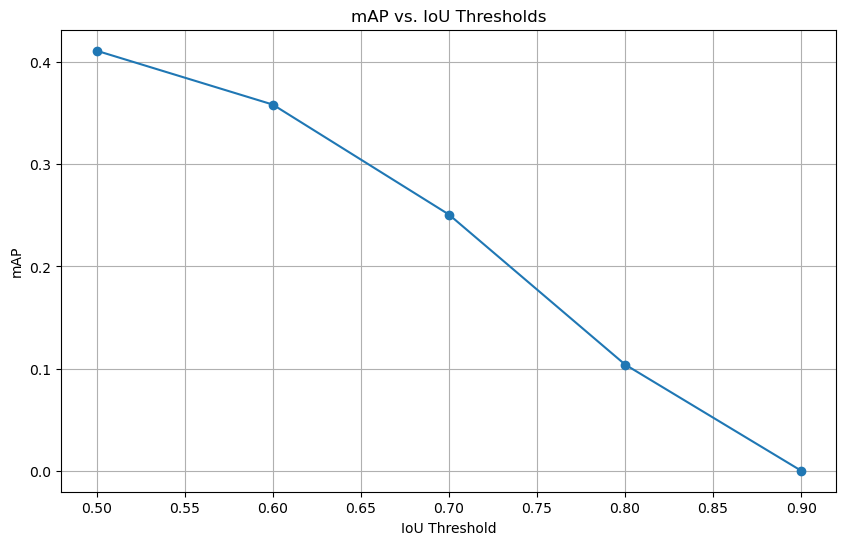

In [18]:
import torch
import os
import matplotlib.pyplot as plt
from torchmetrics.detection.mean_ap import MeanAveragePrecision

# Instantiate GlizzyNet
hotdog_detector = GlizzyNet(num_classes=2, freeze_backbone=True, freeze_rpn=True, freeze_fpn=True)
glizzy_net = hotdog_detector.get_model()

checkpoint = os.path.join("checkpoints_bs64", "model_epoch_15.pth")
glizzy_net.load_state_dict(torch.load(checkpoint, map_location=torch.device(device)))

glizzy_net.eval()

def plot_map_vs_iou(model, loader, iou_thresholds, num_batches=1):
    map_values = []

    for iou_threshold in iou_thresholds:
        # print(map_values)
        # Initialize the MeanAveragePrecision metric for the current iou threshold
        map_metric = MeanAveragePrecision(iou_thresholds=[iou_threshold], class_metrics=False)

        model.eval()
        with torch.no_grad():
            for batch_num, (images, targets) in enumerate(loader):
                images = [image.to(device) for image in images]
                outputs = model(images)
                
                # Prepare predictions and ground truths in the format required by torchmetrics
                preds = []
                for output in outputs:
                    preds.append({
                        "boxes": output["boxes"],
                        "scores": output["scores"],
                        "labels": torch.zeros(len(output["boxes"]), dtype=torch.int32)  # Ensuring label is integer
                    })

                ground_truths = []
                for target in targets:
                    ground_truths.append({
                        "boxes": target["boxes"],
                        "labels": torch.zeros(len(target["boxes"]), dtype=torch.int32)  # Ensuring label is integer
                    })
                
                # Update the metric with the current batch predictions and ground truths
                map_metric.update(preds, ground_truths)
            
                if batch_num == num_batches: break

        # Compute mAP for the current IoU threshold
        results = map_metric.compute()
        map_value = results['map'].item()  # Extract the mAP value
        map_values.append(map_value)

    # Plot mAP vs IoU Thresholds
    plt.figure(figsize=(10, 6))
    plt.plot(iou_thresholds, map_values, marker='o', linestyle='-')
    plt.xlabel('IoU Threshold')
    plt.ylabel('mAP')
    plt.title('mAP vs. IoU Thresholds')
    plt.grid(True)
    plt.show()

# Make a range of IoU thresholds to evaluate
iou_thresholds = [i / 100.0 for i in range(50, 100, 10)]  # From 0.5 to 1.0

# Plot mAP as a function of IoU threshold
plot_map_vs_iou(glizzy_net, val_loader, iou_thresholds, num_batches=1)

# Qualitative testing

We visually inspect how glizzy net performs against the truth bounding boxes (green).

With IoU threshold=0.5


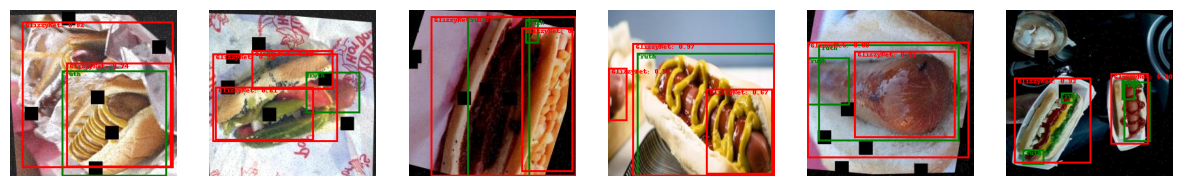

With IoU threshold=0.7


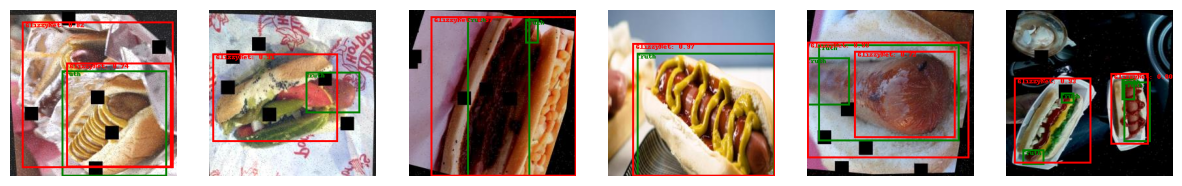

In [46]:
import torch
import os

hotdog_detector = GlizzyNet(num_classes=2, freeze_backbone=True, freeze_rpn=True, freeze_fpn=True)
glizzy_net = hotdog_detector.get_model()

checkpoint = os.path.join("checkpoints_bs64", "model_epoch_15.pth")
glizzy_net.load_state_dict(torch.load(checkpoint, map_location=torch.device(device)))

glizzy_net.eval()

images, targets = next(iter(val_loader))

# Using our visualize_images function, we can plot the truth and glizzy
print(f"With IoU threshold=0.5")
visualize_images(images, targets, glizzy_net, device, iou_threshold=0.5)
print(f"With IoU threshold=0.7")
visualize_images(images, targets, glizzy_net, device, iou_threshold=0.7)